# Data Visualization - Mussel Baskets

## Visualization

#### Function Descriptions and Usage

##### `verify_access_code`
- **Purpose**: Verifies the access code provided by the user.
- **Usage**: Hashes the input code using SHA256 and compares it to a pre-defined hashed access code. This ensures only users with the correct access code can proceed to use the application.

##### `load_trained_model`
- **Purpose**: Loads a trained machine learning model from a file.
- **Usage**: Uses Joblib to load the model necessary for making growth predictions.

##### `load_data`
- **Purpose**: Loads data from a CSV file into a Pandas DataFrame.
- **Usage**: Reads various datasets needed for the application.

##### `create_sidebar`
- **Purpose**: Creates a sidebar for user settings in the Streamlit app.
- **Usage**: Allows selection of year range and locations. The selections are returned as a tuple to filter the data displayed on the dashboard.

##### `display_main_map`
- **Purpose**: Displays an interactive map with mussel growth data.
- **Usage**: Uses Plotly Express to show bubbles representing mussel growth, colored by a selected feature and animated by month. Filters data based on user-selected years and locations.

##### `display_graphs`
- **Purpose**: Displays interactive graphs for various metrics over time.
- **Usage**: Uses Plotly Graph Objects to plot data based on user-selected years and locations, providing visual insights into mussel growth trends.

##### `display_feature_vs_target_analysis`
- **Purpose**: Compares a selected feature against Growth (g per day).
- **Usage**: Creates an interactive graph using user-selected years and locations to filter and plot the data for detailed feature analysis.

##### `haversine`
- **Purpose**: Calculates the great-circle distance between two points on the Earth's surface.
- **Usage**: Given latitude and longitude, computes the distance, useful for finding the nearest environmental data point.

##### `get_nearest_environmental_data`
- **Purpose**: Finds the nearest environmental data point for a specific month.
- **Usage**: Filters data by month and calculates distances using the haversine function to return the closest data point, providing accurate environmental data inputs for growth predictions.

##### `predict_growth`
- **Purpose**: Predicts mussel growth based on user inputs and additional environmental features.
- **Usage**: Uses the trained model to make predictions for each monitoring period from May to October and returns the results in a DataFrame.

##### `display_prediction_interface`
- **Purpose**: Creates the interface for mussel growth prediction.
- **Usage**: Allows users to input latitude, longitude, and individual weight, then predicts growth based on these inputs. Displays the predictions and a corresponding plot.

##### `display_data`
- **Purpose**: Displays the interactive map, graphs, and prediction interface in the Streamlit app.
- **Usage**: Uses sidebar selections to filter data and calls relevant display functions to show visualizations and predictions.

##### `main`
- **Purpose**: Runs the Streamlit app for the Mussel Growth Trends Dashboard.
- **Usage**: Handles access control, loads necessary data and model files upon successful access verification, and calls the `display_data` function to render the dashboard.

#### Summary

This Streamlit application visualizes mussel growth data through interactive maps and graphs, and allows users to predict growth based on various environmental factors. The `verify_access_code` function secures access to the app, while `load_trained_model` and `load_data` handle loading necessary files. The sidebar for user input is created by `create_sidebar`. The **core** display functions `display_main_map`, `display_graphs`, and `display_feature_vs_target_analysis` render the main visual elements based on user inputs. Environmental data is managed through `get_nearest_environmental_data`, with distance calculations done by `haversine`. Growth predictions are facilitated by `predict_growth` and its interface is managed by `display_prediction_interface`. The `display_data` function integrates these components into the main app, which is initialized and run by the `main` function.

#### Visualization

In [22]:
%%writefile mussel_visualization.py

# Streamlit for creating the web application interface
import streamlit as st

# Pandas for data manipulation and analysis
import pandas as pd

# NumPy for numerical operations
import numpy as np

# Plotly for creating interactive plots and charts
import plotly.graph_objects as go
import plotly.express as px

# Matplotlib for additional plotting utilities
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Joblib for model serialization
import joblib

# Hashlib for hashing access codes
import hashlib

# Math functions for distance calculations
from math import radians, sin, cos, sqrt, atan2

access_granted = False

st.set_page_config(layout="wide", page_title="Mussel Growth Trends Dashboard", page_icon="🐚")

def verify_access_code(input_code):
    """
    Verifies the access code provided by the user.

    This function hashes the input code using SHA256 and compares it to a pre-defined 
    hashed access code. It is used to ensure that only users with the correct access 
    code can proceed to use the application.

    Args:
        input_code (str): The access code input by the user.

    Returns:
        bool: True if the input code matches the pre-defined hashed access code, False otherwise.
    """
    # Hash the input code using SHA256
    hashed_input = hashlib.sha256(input_code.encode()).hexdigest()

    # Pre-defined hashed version of the correct access code
    # Note: To generate this hash for a new access code, use the following code snippet in a separate cell:
    # import hashlib
    # correct_code = 'your_desired_access_code'
    # print(hashlib.sha256(correct_code.encode()).hexdigest())
    hashed_access_code = 'd0601b8185961d8e3e0ea3bbbeca893e630abfa2f9617a5122a431f498bcfe6e'

    # Compare the hashed input code with the pre-defined hashed access code
    return hashed_input == hashed_access_code

def load_trained_model(file_path):
    """
    Loads the trained model from a file.

    Args:
        file_path (str): The path to the model file.

    Returns:
        model: The loaded model.
    """
    return joblib.load(file_path)

def load_data(file):
    """
    Loads the data from a CSV file.

    Args:
        file (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded DataFrame.
    """
    return pd.read_csv(file)

def create_sidebar(df):
    """
    Creates a sidebar in the Streamlit app for user settings, allowing selection of years and locations.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        tuple: A tuple containing the selected year range and location selection.
    """
    # Set the title and header for the sidebar
    st.sidebar.title("Settings")
    
    # Add spacing
    st.sidebar.markdown("<br>", unsafe_allow_html=True)
    
    # Multiselect widget for selecting year(s)
    year_range = st.sidebar.multiselect(
        '📅 Select Year(s)',
        options=list(range(int(df['Year'].min()), int(df['Year'].max()) + 1)), 
        default=list(range(int(df['Year'].min()), int(df['Year'].max()) + 1))
    )
    
    # Instruction for year selection
    st.sidebar.markdown("""
    <div style="border: 1px solid #ccc; padding: 10px; border-radius: 5px; font-size: 12px; margin-top: -10px;">
    <b>Note</b>: Selecting more than one year will average the values for all selected years.
    </div>
    """, unsafe_allow_html=True)
    
    # Add spacing
    st.sidebar.markdown("<br>", unsafe_allow_html=True)
    
    # Prepare location options by combining 'System' and 'Plot Location'
    location_options = df[['System', 'Plot Location']].drop_duplicates()
    location_options['Location_System'] = location_options['System'] + ' - ' + location_options['Plot Location']
    
    # Multiselect widget for selecting locations
    location_selection = st.sidebar.multiselect(
        '📍 Select Locations',
        options=location_options['Location_System'].sort_values()
    )
    
    # Instruction for location selection
    st.sidebar.markdown("""
    <div style="border: 1px solid #ccc; padding: 10px; border-radius: 5px; font-size: 12px; margin-top: -10px;">
    <b>Note</b>: If no location is selected, the data will be averaged per system.
    Selecting more than one location will display data per location.
    </div>
    """, unsafe_allow_html=True)
    
    # Return the selected year range and location selection
    return year_range, location_selection

def display_main_map(df, year_range, location_selection):
    """
    Displays an interactive map with bubbles representing mussel growth data, colored by a selected feature and animated by month.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        year_range (list): List of selected years.
        location_selection (list): List of selected locations.
    """
    # User selection for the feature to color the map bubbles
    selected_color_feature = st.selectbox('Select feature for bubble color', [
        'Precipitation', 'Sea Surface Temperature (C)', 'Chlorophyll (mg per m3)', 'Turbidity (FTU)'
    ], help="The color scale represents the selected feature, indicating its intensity.")
    
    # Add a custom information box
    st.markdown("""
        <div style="background-color: #fff3cd; padding: 10px; border-radius: 5px; color: #856404; font-size: 16px; margin-bottom: 20px;">
            <strong>Note</strong>: Color scale indicates the intensity of the selected feature, and bubble size represents the magnitude of growth (g per day).
        </div>
    """, unsafe_allow_html=True)

    # Filter the dataframe based on the selected years
    df_filtered = df[df['Year'].isin(year_range)]

    # If specific locations are selected, filter the dataframe accordingly
    if location_selection:
        df_filtered['Location_System'] = df_filtered['System'] + ' - ' + df_filtered['Plot Location']
        df_filtered = df_filtered[df_filtered['Location_System'].isin(location_selection)]

    # Exclude data for Monitoring Period 0
    df_filtered = df_filtered[df_filtered['Monitoring Period'] > 0]

    # Select only numeric columns for aggregation
    numeric_cols = df_filtered.select_dtypes(include=['number']).columns.tolist()
    grouping_cols = ['lat', 'lon', 'Plot Location', 'System', 'Month', 'Monitoring Period']
    agg_cols = [col for col in numeric_cols if col not in grouping_cols]

    # Group the filtered data by specific columns and calculate the mean for each group
    df_grouped = df_filtered.groupby(grouping_cols)[agg_cols].mean().round(2).reset_index()

    # Rename columns for better readability in the hover information
    df_grouped.rename(columns={'lat': 'Latitude', 'lon': 'Longitude'}, inplace=True)

    # Sort the grouped data by Monitoring Period
    df_grouped.sort_values(by='Monitoring Period', inplace=True)

    # Create the scatter mapbox figure using Plotly Express
    fig = px.scatter_mapbox(
        df_grouped,
        lat="Latitude",
        lon="Longitude",
        color=selected_color_feature,
        size="Growth (g per day)",
        size_max=25,
        hover_name="Plot Location",
        hover_data={
            "System": True,
            "Latitude": False,
            "Longitude": False,
            selected_color_feature: True,
            "Growth (g per day)": True,
            "Month": True
        },
        animation_frame="Monitoring Period",
        mapbox_style="carto-positron",
        color_continuous_scale=px.colors.sequential.Viridis,
        zoom=7,
        center={"lat": df['lat'].mean(), "lon": df['lon'].mean()}
    )

    # Update the layout of the figure
    fig.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        mapbox=dict(bearing=0, pitch=0),
        coloraxis_colorbar=dict(title=selected_color_feature),
        height=800
    )

    # Display the figure using Streamlit
    st.plotly_chart(fig, use_container_width=True)
    
def display_graphs(df, year_range, location_selection):
    """
    Displays interactive graphs showing various metrics over time.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        year_range (list): List of selected years.
        location_selection (list): List of selected locations.
    """
    st.header("📈 Graphs")  # Add a header for the graphs section
    
    # Define the metrics to be plotted, ordered by importance
    metrics = ['Growth (g per day)', 'Chlorophyll (mg per m3)', 'Sea Surface Temperature (C)', 
               'Turbidity (FTU)', 'Precipitation', 'Individual Weight (g)', 
               'Depth (m)', 'Average Flow Speed (mps)', 'Maximum Flow Speed (mps)', 'Living Mussel Count']

    # Create two columns for displaying the plots
    col1, col2 = st.columns(2)
    
    # Define colors for different systems
    system_colors = {'OS': 'orange', 'WAD': 'green'}
    
    # Create a colormap for location colors
    cmap = plt.get_cmap('tab10')
    location_colors = [mcolors.to_hex(cmap(i)) for i in np.linspace(0, 1, len(location_selection))]

    # Filter the dataframe based on the selected years
    df_filtered = df[df['Year'].isin(year_range)]

    # Initialize a counter to alternate between columns
    counter = 0

    # Loop through each metric to create a plot
    for metric in metrics:
        fig = go.Figure()  # Create a new figure for each metric
        added_systems = set()  # Track systems that have been added to the plot

        # If specific locations are selected, plot each location's data
        if location_selection:
            # Create a dictionary to map locations to colors
            location_colors_dict = {location: color for location, color in zip(location_selection, location_colors)}
            
            # Loop through each selected location
            for location in location_selection:
                if ' - ' in location:
                    # Split the location string into system and plot location
                    system, plot_location = location.split(' - ', 1)
                    
                    # Filter the data for the specific system and plot location
                    df_location = df_filtered[(df_filtered['System'] == system) & 
                                              (df_filtered['Plot Location'] == plot_location)].dropna()
                    
                    # Group by 'Month' and 'Monitoring Period', and calculate the mean for the metric
                    df_location_avg = df_location.groupby(['Month', 'Monitoring Period'])[metric].mean().reset_index()
                    
                    # Sort the grouped data by 'Monitoring Period'
                    df_location_avg.sort_values(by='Monitoring Period', inplace=True)

                    # Add a trace for the location's data
                    fig.add_trace(go.Scatter(x=df_location_avg['Month'], y=df_location_avg[metric], 
                                             mode='lines+markers', 
                                             name=f'Average at {plot_location}', 
                                             line=dict(shape='spline', color=location_colors_dict[location]),
                                             marker=dict(symbol='circle')))
                    
                    # Add system average line if not already added
                    if system not in added_systems:
                        df_system_avg = df_filtered[df_filtered['System'] == system].groupby(['Month', 'Monitoring Period'])[metric].mean().reset_index()
                        df_system_avg.sort_values(by='Monitoring Period', inplace=True)
                        fig.add_trace(go.Scatter(x=df_system_avg['Month'], y=df_system_avg[metric], 
                                                 mode='lines+markers', 
                                                 line=dict(dash='dash', shape='spline', color=system_colors[system]), 
                                                 name=f'Average in {system} System',
                                                 marker=dict(symbol='circle')))
                        added_systems.add(system)
                else:
                    st.warning(f"Invalid location format: {location}")
        else:
            # If no specific locations are selected, plot each system's average data
            for system in df['System'].unique():
                df_system_avg = df_filtered[df_filtered['System'] == system].groupby(['Month', 'Monitoring Period'])[metric].mean().reset_index()
                df_system_avg.sort_values(by='Monitoring Period', inplace=True)
                fig.add_trace(go.Scatter(x=df_system_avg['Month'], y=df_system_avg[metric], 
                                         mode='lines+markers', 
                                         name=f'Average {system}', 
                                         line=dict(shape='spline', color=system_colors[system]),
                                         marker=dict(symbol='circle')))

        # Update the layout of the figure
        fig.update_layout(template="plotly_dark", title=f"{metric} Trends - {', '.join(map(str, year_range))}")
        
        # Alternate between the two columns for displaying the charts
        with (col1 if counter % 2 == 0 else col2):
            st.plotly_chart(fig, use_container_width=True)
        
        counter += 1  # Increment the counter to alternate columns
            
def display_feature_vs_target_analysis(df, year_range, location_selection):
    """
    Displays an interactive graph comparing a selected feature against Growth (g per day).

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        year_range (list): List of selected years.
        location_selection (list): List of selected locations.
    """
    st.header("🔍 Growth (g per day) Feature Analysis")  # Header for the analysis section
    
    # Add a custom information box
    st.markdown("""
        <div style="background-color: #fff3cd; padding: 10px; border-radius: 5px; color: #856404; font-size: 16px; margin-bottom: 20px;">
            <strong>Note</strong>: Please note that the visualizations are generated directly from the raw data. They may present insights that differ from your existing knowledge or expectations. Additionally, the selection of years and locations will influence the data presented in these visualizations.
        </div>
    """, unsafe_allow_html=True)
    
    # Define the available metrics
    metrics = ['Growth (g per day)', 'Chlorophyll (mg per m3)', 'Sea Surface Temperature (C)', 
               'Turbidity (FTU)', 'Precipitation', 'Individual Weight (g)', 
               'Depth (m)', 'Average Flow Speed (mps)', 'Maximum Flow Speed (mps)', 'Living Mussel Count']
    
    # Create a list of feature options excluding 'Growth (g per day)'
    feature_options = [metric for metric in metrics if metric != 'Growth (g per day)']
    
    # Selectbox for the user to choose a feature to plot against 'Growth (g per day)'
    selected_feature = st.selectbox('Select a feature to plot against Growth (g per day)', options=feature_options)

    if selected_feature:
        # Filter the dataframe based on the selected years
        df_filtered = df[df['Year'].isin(year_range)]
        
        # If specific locations are selected, filter based on those locations
        if location_selection:
            df_filtered['Location_System'] = df_filtered['System'] + ' - ' + df_filtered['Plot Location']
            df_filtered = df_filtered[df_filtered['Location_System'].isin(location_selection)]
        
        # Create a new figure for plotting
        fig = go.Figure()

        if location_selection:
            # Loop through each selected location
            for location in location_selection:
                if ' - ' in location:
                    # Split the location string into system and plot location
                    system, plot_location = location.split(' - ', 1)
                    
                    # Filter the data for the specific system and plot location
                    df_location = df_filtered[(df_filtered['System'] == system) & 
                                              (df_filtered['Plot Location'] == plot_location)].dropna(subset=[selected_feature, 'Growth (g per day)'])
                    
                    # Group by 'Month' and 'Monitoring Period', and calculate the mean for the selected feature and target
                    df_grouped = df_location.groupby(['Month', 'Monitoring Period'])[[selected_feature, 'Growth (g per day)']].mean().reset_index()
                    
                    # Sort the grouped data by 'Monitoring Period'
                    df_grouped.sort_values(by='Monitoring Period', inplace=True)

                    # Add a trace for the selected feature
                    fig.add_trace(go.Scatter(x=df_grouped['Month'], y=df_grouped[selected_feature], mode='lines+markers', 
                                             name=f'{selected_feature} at {plot_location}', yaxis='y1', line_shape='spline'))
                    
                    # Add a trace for 'Growth (g per day)'
                    fig.add_trace(go.Scatter(x=df_grouped['Month'], y=df_grouped['Growth (g per day)'], mode='lines+markers', 
                                             name=f'Growth (g per day) at {plot_location}', line=dict(width=4, dash='dash'), yaxis='y2', line_shape='spline'))
        else:
            # If no specific locations are selected, plot the data for each system
            for system in df['System'].unique():
                df_system = df_filtered[df_filtered['System'] == system].dropna(subset=[selected_feature, 'Growth (g per day)'])
                
                # Group by 'Month' and 'Monitoring Period', and calculate the mean for the selected feature and target
                df_grouped = df_system.groupby(['Month', 'Monitoring Period'])[[selected_feature, 'Growth (g per day)']].mean().reset_index()
                
                # Sort the grouped data by 'Monitoring Period'
                df_grouped.sort_values(by='Monitoring Period', inplace=True)

                # Add a trace for the selected feature
                fig.add_trace(go.Scatter(x=df_grouped['Month'], y=df_grouped[selected_feature], mode='lines+markers', 
                                         name=f'{selected_feature} in {system} System', yaxis='y1', line_shape='spline'))
                
                # Add a trace for 'Growth (g per day)'
                fig.add_trace(go.Scatter(x=df_grouped['Month'], y=df_grouped['Growth (g per day)'], mode='lines+markers', 
                                         name=f'Growth (g per day) in {system} System', line=dict(width=4, dash='dash'), yaxis='y2', line_shape='spline'))

        # Update the layout of the figure
        fig.update_layout(
            title=f"{selected_feature} vs Growth (g per day)",
            xaxis_title='Month',
            yaxis=dict(title=f'{selected_feature} Values', side='left'),
            yaxis2=dict(title='Growth (g per day)', overlaying='y', side='right'),
            height=600,
            template="plotly_dark"
        )

        # Display the figure
        st.plotly_chart(fig, use_container_width=True)
        
def display_location_rankings(df, year_range):
    """
    Displays a ranking table of locations based on the average of selected metrics for the given years.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        year_range (list): The list of selected years.
    """
    # Filter the dataframe for the selected years
    df_filtered = df[df['Year'].isin(year_range)]
    
    # Select the metrics to rank locations
    metrics = ['Growth (g per day)', 'Precipitation', 'Sea Surface Temperature (C)', 'Chlorophyll (mg per m3)', 'Turbidity (FTU)']
    
    # Calculate the average of each metric for each location and system
    df_rankings = df_filtered.groupby(['Plot Location', 'System'])[metrics].mean().round(4).reset_index()
    
    # Sort by 'Growth (g per day)' in descending order
    df_rankings = df_rankings.sort_values(by='Growth (g per day)', ascending=False).reset_index(drop=True)

    # Display the rankings table with a header
    st.header(f"📊 Location Rankings Based on Average Metrics for Selected Years ({', '.join(map(str, year_range))})")
    
    # Add a custom information box
    st.markdown("""
        <div style="background-color: #fff3cd; padding: 10px; border-radius: 5px; color: #856404; font-size: 16px; margin-bottom: 20px;">
            <strong>Note</strong>: The table below shows the ranking of locations based on the average of selected metrics for the selected years.
        </div>
    """, unsafe_allow_html=True)
    
    # Display the dataframe as a table
    st.dataframe(df_rankings, use_container_width=True)

def haversine(latitude1, longitude1, latitude2, longitude2):
    """
    Calculate the great-circle distance between two points 
    on the Earth's surface given their latitude and longitude.
    
    Parameters:
    - latitude1: Latitude of the first point in decimal degrees.
    - longitude1: Longitude of the first point in decimal degrees.
    - latitude2: Latitude of the second point in decimal degrees.
    - longitude2: Longitude of the second point in decimal degrees.
    
    Returns:
    - distance: The distance between the two points in kilometers.
    """
    # Radius of the Earth in kilometers
    earth_radius_km = 6371.0

    # Convert latitude and longitude from degrees to radians
    delta_latitude = radians(latitude2 - latitude1)
    delta_longitude = radians(longitude2 - longitude1)
    
    # Apply the Haversine formula to calculate the great-circle distance
    a = sin(delta_latitude / 2)**2 + cos(radians(latitude1)) * cos(radians(latitude2)) * sin(delta_longitude / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Calculate the distance
    distance = earth_radius_km * c

    return distance

def get_nearest_environmental_data(latitude, longitude, dataframe):
    """
    Calculates the distance between a given location and each data point in a DataFrame containing environmental data.
    Then, returns the first (nearest) data point for each monitoring period.

    Args:
        latitude (float): The latitude coordinate of the reference location.
        longitude (float): The longitude coordinate of the reference location.
        dataframe (pd.DataFrame): A DataFrame containing environmental data, including columns for 'Latitude', 'Longitude', and other relevant information.

    Returns:
        pd.DataFrame: A new DataFrame containing the nearest environmental data for each monitoring period.
    """

    # Calculate the distance (in kilometers) for each data point in the DataFrame using the haversine formula
    dataframe['distance'] = dataframe.apply(
        lambda row: haversine(latitude, longitude, row['Latitude'], row['Longitude']), axis=1
    )

    # Sort the DataFrame by the calculated distance (ascending order)
    dataframe = dataframe.sort_values(by='distance')

    # Group the data by monitoring period and select the first (nearest) data point for each group
    nearest_data = dataframe.groupby('Monitoring Period').first().reset_index()

    return nearest_data

def predict_growth(year, lat, lon, initial_weight, depth, avg_flow_speed, max_flow_speed):
    """
    Predict mussel growth based on user inputs and additional environmental features.

    Parameters:
    - year: Year for which the prediction is to be made.
    - lat: Latitude of the location.
    - lon: Longitude of the location.
    - initial_weight: Initial weight of the mussel.
    - depth: Depth of the water.
    - avg_flow_speed: Average flow speed of the water.
    - max_flow_speed: Maximum flow speed of the water.

    Returns:
    - predictions: DataFrame with columns 'Month' and 'Growth (g per day)'.
    """
    # Load environmental data
    df_environment = pd.read_csv('./Data/Environment Data.csv')

    # Get nearest environmental data for Monitoring Period 0-6
    nearest_data = get_nearest_environmental_data(lat, lon, df_environment)

    predictions = []
    months = ['May', 'June', 'July', 'August', 'September', 'October']

    for period in range(1, 7):  # Monitoring periods 1 to 6
        # Get the current and previous period data
        current_data = nearest_data[nearest_data['Monitoring Period'] == period].iloc[0]
        lag_data = nearest_data[nearest_data['Monitoring Period'] == period - 1].iloc[0]
        
        # Create input data dictionary for prediction
        input_data = {
            'Monitoring Period': [period],
            'Year': [year],
            'Depth (m)': [depth],
            'Average Flow Speed (mps)': [avg_flow_speed],
            'Maximum Flow Speed (mps)': [max_flow_speed],
            'Water Temperature (C)': [current_data['Water Temperature (C)']],
            'Chlorophyll': [current_data['Chlorophyll']],
            'Turbidity (FTU)': [current_data['Turbidity (FTU)']],
            'Precipitation': [current_data['Precipitation']],
            'Individual Weight (g)_lag': [initial_weight],
            'Water Temperature (C)_lag': [lag_data['Water Temperature (C)']],
            'Chlorophyll_lag': [lag_data['Chlorophyll']],
            'Turbidity (FTU)_lag': [lag_data['Turbidity (FTU)']],
            'Precipitation_lag': [lag_data['Precipitation']]
        }

        # Convert input data dictionary to DataFrame
        input_df = pd.DataFrame(input_data)

        # Predict growth using the trained model
        prediction = loaded_model.predict(input_df[['Monitoring Period', 'Year', 'Depth (m)', 'Average Flow Speed (mps)', 'Maximum Flow Speed (mps)', 'Water Temperature (C)', 'Chlorophyll', 'Turbidity (FTU)', 'Precipitation', 'Individual Weight (g)_lag', 'Water Temperature (C)_lag', 'Chlorophyll_lag', 'Turbidity (FTU)_lag', 'Precipitation_lag']])[0]
        predictions.append(prediction)
        
        # Update initial_weight for next period
        initial_weight += prediction * 30  # Update the individual weight for the next month

    # Create a DataFrame for predictions with 'Month' and 'Growth (g per day)'
    prediction_df = pd.DataFrame({
        'Month': months,
        'Growth (g per day)': predictions
    })

    return prediction_df


def display_prediction_interface():
    """
    Displays the prediction interface for mussel growth. Allows users to input latitude, longitude, 
    and individual weight, then predicts growth based on these inputs.
    """
    st.header("🔮 Predict Mussel Growth")

    # Custom warning box for model disclaimer
    st.markdown("""
        <div style="background-color: #fff3cd; padding: 10px; border-radius: 5px; color: #856404; font-size: 16px; margin-bottom: 20px;">
            <strong>Disclaimer</strong>: The predictions provided here are based on a trained model. 
            While the model has been developed and tested with historical data, 
            the predictions are not guaranteed to be 100% accurate. 
            Please use these predictions as a guideline and not as a definitive forecast.
        </div>
    """, unsafe_allow_html=True)

    # Initial coordinates for Amsterdam
    initial_lat = 52.3676
    initial_lon = 4.9041

    # User inputs for prediction
    lat = st.number_input('Latitude', value=initial_lat, format="%.6f")
    lon = st.number_input('Longitude', value=initial_lon, format="%.6f")
    year = st.number_input('Year', value=2024, min_value=2024)
    individual_weight = st.number_input('Individual Weight (g)', value=2.0, min_value=0.1)
    depth = st.number_input('Depth (m)', value=10.0, min_value=0.1)
    avg_flow_speed = st.number_input('Average Flow Speed (mps)', value=0.5, min_value=0.1)
    max_flow_speed = st.number_input('Maximum Flow Speed (mps)', value=1.0, min_value=0.1)

    # Button click state initialization
    if 'predict_clicked' not in st.session_state:
        st.session_state['predict_clicked'] = False

    button_placeholder = st.empty()  # Placeholder for the predict button

    # Display the predict button if prediction has not been clicked yet
    if not st.session_state['predict_clicked']:
        if button_placeholder.button("Predict Growth", key="predict"):
            st.session_state['predict_clicked'] = True  # Update state to indicate button was clicked
            with st.spinner('Predicting...'):
                # Perform prediction
                predictions_df = predict_growth(year, lat, lon, individual_weight, depth, avg_flow_speed, max_flow_speed)
                st.session_state['predictions'] = predictions_df  # Store predictions in session state

    # Display predictions and plot if available
    if st.session_state['predict_clicked'] and 'predictions' in st.session_state:
        st.write(st.session_state['predictions'])  # Display predictions DataFrame

        # Create a plot of the predictions
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=st.session_state['predictions']['Month'], 
            y=st.session_state['predictions']['Growth (g per day)'], 
            mode='lines+markers', 
            line_shape='spline'
        ))
        fig.update_layout(
            title="Predicted Growth (g per day) for Each Month", 
            xaxis_title="Month", 
            yaxis_title="Growth (g per day)"
        )
        st.plotly_chart(fig, use_container_width=True)

        # Reset the state for the next prediction
        st.session_state['predict_clicked'] = False
        st.session_state.pop('predictions', None)
        button_placeholder.button("Predict Growth", key="predict_new")
        
def display_data(df):
    """
    Main function to display the interactive map, graphs, and prediction interface in the Streamlit app.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
    """

    # Create the sidebar and get the user's selections
    year_range, location_selection = create_sidebar(df)

    # Apply custom styling using CSS for font family
    st.markdown("""
    <style>
    @import url('https://fonts.googleapis.com/css2?family=Inter&display=swap');
    h1, h2, h3, h4, h5, h6, p {
        font-family: 'Inter', sans-serif;
    }
    </style>
    """, unsafe_allow_html=True)

    # Markdown block to provide an overview and instructions for the app
    st.markdown("""
    > This dashboard visualizes mussel growth data from various locations in the Netherlands. 
    > Use the sidebar to filter data by year and location.
    > The map shows mussel baskets with different colors representing different systems. 
    > Charts below display detailed growth trends. Hover over them for more information.
    """)

    # Display header for the map section
    st.header("🌍 Map")

    # Display the main interactive map
    display_main_map(df, year_range, location_selection)
    
    # Add a divider for better visual separation
    st.divider()

    # Display graphs for various metrics over time
    display_graphs(df, year_range, location_selection)

    # Add another divider
    st.divider()

    # Display analysis comparing selected features against Growth (g per day)
    display_feature_vs_target_analysis(df, year_range, location_selection)
    
    # Add another divider
    st.divider()

    # Display location rankings
    display_location_rankings(df, year_range)
    
    # Add a final divider
    st.divider()
    
    # Display the prediction interface for predicting mussel growth
    display_prediction_interface()

def main():
    """
    Main function to run the Streamlit app for Mussel Growth Trends Dashboard.
    """
    # Set the title of the Streamlit app
    st.title('🦪 Mussel Growth Trends Dashboard'.upper())

    # Check if 'access_granted' exists in the session state, if not, initialize it as False
    if "access_granted" not in st.session_state:
        st.session_state.access_granted = False

    # Access control: If access has not been granted
    if not st.session_state.access_granted:
        # Create three columns for layout, with the middle column for the access code input
        cols = st.columns([1, 2, 1])
        with cols[1]:
            # Create a password input field in the middle column for the access code
            access_code = st.text_input("Enter access code", type="password")
            # Create a submit button in the middle column
            if st.button("Submit"):
                # Verify the access code
                if verify_access_code(access_code):
                    # If the access code is correct, set 'access_granted' to True and refresh the page
                    st.session_state.access_granted = True
                    st.experimental_rerun()()  # Refresh the page to reload with granted access
                else:
                    # If the access code is incorrect, display an error message
                    st.error("Access denied. Please enter the correct access code.")
            else:
                # If the submit button is not clicked, display a message prompting for the access code
                st.markdown("""
                > This dashboard allows you to explore the growth trends of mussels across various locations and periods. 
                > Please enter the access code to continue.
                """)
    else:
        # If access is granted, proceed to load necessary files
        global loaded_model, df_modeling  # Define as global variables

        # Load the trained model
        loaded_model = load_trained_model('./random_forest_model.pkl')
        
        # Load the main data
        df_modeling = load_data('./Data/It3 - Mussel + SatML + Weather (Lag Features).csv')

        # Drop 'Plot Location' column from the main DataFrame as it is not needed
        df_modeling.drop(columns=['Plot Location'], inplace=True)

        # Load the main dataset and ensure the 'Year' column is of type int
        df = load_data('./Data/Mussel + Satellite + Weather.csv')
        df['Year'] = df['Year'].astype(int)

        # Display the data and visualizations in the app
        display_data(df)

if __name__ == '__main__':
    main()

Overwriting mussel_visualization.py


##### *Get Access Code Hashing*

In [17]:
import hashlib

# Define the access code
access_code = '1'

# Hash the access code using SHA-256
hashed_access_code = hashlib.sha256(access_code.encode()).hexdigest()

# Print the hashed access code
print(hashed_access_code)

6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b


## Model Testing

#### Environmental Data

In [40]:
import pandas as pd

df = pd.read_csv('./Data/Environment Data.csv')

In [41]:
df.head()

,Latitude,Longitude,Monitoring Period,Water Temperature (C),Chlorophyll,Turbidity (FTU),Precipitation
0,51.5352,3.9374,0.0,8.798064,2.081838,2.468239,752.0
1,51.5352,3.9374,1.0,11.872175,2.608764,2.519642,780.0
2,51.5352,3.9374,2.0,16.682196,2.076825,3.153997,1406.0
3,51.5352,3.9374,3.0,19.553848,2.540115,2.006872,558.0
4,51.5352,3.9374,4.0,21.428988,3.670267,3.284976,470.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Latitude               147 non-null    float64
 1   Longitude              147 non-null    float64
 2   Monitoring Period      147 non-null    float64
 3   Water Temperature (C)  147 non-null    float64
 4   Chlorophyll            147 non-null    float64
 5   Turbidity (FTU)        147 non-null    float64
 6   Precipitation          147 non-null    float64
dtypes: float64(7)
memory usage: 8.2 KB


### Model

##### *Random Forest*

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

In [24]:
import matplotlib

# Check the version of matplotlib
matplotlib.__version__

'3.7.1'

In [3]:
df_main = pd.read_csv('./Data/It3 - Mussel + SatML + Weather (Lag Features).csv')

In [4]:
df_main.head()

,Plot Location,Monitoring Period,Year,Depth (m),Average Flow Speed (mps),Maximum Flow Speed (mps),Number of Days,Living Mussel Count,Growth (g per day),Water Temperature (C),Chlorophyll,Turbidity (FTU),Precipitation,Living Mussel Count_lag,Ash Free Dry Weight (g)_lag,Individual Weight (g)_lag,Water Temperature (C)_lag,Chlorophyll_lag,Turbidity (FTU)_lag,Precipitation_lag
0,Hammen 102,0,0,-9.48,0.29,0.68,33.0,81.0,0.0395,12.592884,2.453270,2.552468,492.0,80.0,0.100018,2.380000,10.994884,3.038504,2.812276,398.0
1,Hammen 102,1,0,-9.48,0.29,0.68,26.0,71.0,0.0573,18.219050,1.848944,3.248280,436.0,81.0,0.251577,3.682716,12.592884,2.453270,2.552468,492.0
2,Hammen 102,2,0,-9.48,0.29,0.68,29.0,60.0,0.0265,19.932183,1.988679,3.736882,2766.0,71.0,0.391079,5.173239,18.219050,1.848944,3.248280,436.0
3,Hammen 102,3,0,-9.48,0.29,0.68,33.0,69.0,0.0553,19.440408,1.840733,2.985607,2266.0,60.0,0.505918,5.943000,19.932183,1.988679,3.736882,2766.0
4,Hammen 102,4,0,-9.48,0.29,0.68,31.0,77.0,0.0267,17.690582,1.036472,2.901599,3044.0,69.0,0.658877,7.766522,19.440408,1.840733,2.985607,2266.0


In [5]:
features = ['Monitoring Period',
            'Year',
            'Depth (m)',
            'Average Flow Speed (mps)',
            'Maximum Flow Speed (mps)',
            'Water Temperature (C)',
            'Chlorophyll',
            'Turbidity (FTU)', 
            'Precipitation',
            'Individual Weight (g)_lag',
            'Water Temperature (C)_lag',
            'Chlorophyll_lag',
            'Turbidity (FTU)_lag',
            'Precipitation_lag']

target = 'Growth (g per day)'

In [6]:
X = df_main[features]
y = df_main[target]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Buat model Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Latih model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [9]:
# Prediksi dengan data pengujian
y_pred = model.predict(X_test)

# Hitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 0.0007137763532364865
R² Score: 0.26866679248049663


In [17]:
# Save the model to a file
joblib.dump(model, './random_forest_model.pkl')
print("Model saved successfully.")

Model saved successfully.


In [10]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius bumi dalam kilometer

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

In [11]:
def get_nearest_environmental_data(latitude, longitude, dataframe):
    dataframe['distance'] = dataframe.apply(
        lambda row: haversine(latitude, longitude, row['Latitude'], row['Longitude']), axis=1
    )
    nearest_data = dataframe.sort_values(by='distance').groupby('Monitoring Period').first().reset_index()
    return nearest_data

In [15]:
def predict_growth(year, lat, lon, initial_weight, depth, avg_flow_speed, max_flow_speed):
    """
    Predict mussel growth based on user inputs and additional environmental features.

    Parameters:
    - year: Year for which the prediction is to be made.
    - lat: Latitude of the location.
    - lon: Longitude of the location.
    - initial_weight: Initial weight of the mussel.
    - depth: Depth of the water.
    - avg_flow_speed: Average flow speed of the water.
    - max_flow_speed: Maximum flow speed of the water.

    Returns:
    - predictions: DataFrame with columns 'Month' and 'Growth (g per day)'.
    """
    # Load environmental data
    df_environment = pd.read_csv('./Data/Environment Data.csv')

    # Get nearest environmental data for Monitoring Period 0-6
    nearest_data = get_nearest_environmental_data(lat, lon, df_environment)

    # Initialize lists to store predictions and corresponding months
    predictions = []
    months = ['May', 'June', 'July', 'August', 'September', 'October']

    # Loop through monitoring periods 1 to 6 (representing May to October)
    for period in range(1, 7):
        # Get the current period data and lag data (previous period)
        current_data = nearest_data[nearest_data['Monitoring Period'] == period].iloc[0]
        lag_data = nearest_data[nearest_data['Monitoring Period'] == (period - 1)].iloc[0]
        
        # Create a dictionary with input data for prediction
        input_data = {
            'Monitoring Period': [period],
            'Year': [year],
            'Depth (m)': [depth],
            'Average Flow Speed (mps)': [avg_flow_speed],
            'Maximum Flow Speed (mps)': [max_flow_speed],
            'Water Temperature (C)': [current_data['Water Temperature (C)']],
            'Chlorophyll': [current_data['Chlorophyll']],
            'Turbidity (FTU)': [current_data['Turbidity (FTU)']],
            'Precipitation': [current_data['Precipitation']],
            'Individual Weight (g)_lag': [initial_weight],
            'Water Temperature (C)_lag': [lag_data['Water Temperature (C)']],
            'Chlorophyll_lag': [lag_data['Chlorophyll']],
            'Turbidity (FTU)_lag': [lag_data['Turbidity (FTU)']],
            'Precipitation_lag': [lag_data['Precipitation']]
        }

        # Convert the input data dictionary to a DataFrame
        input_df = pd.DataFrame(input_data)

        # Predict growth using the trained model
        prediction = model.predict(input_df[features])[0]
        predictions.append(prediction)
        
        # Update the initial weight for the next month by adding the predicted growth
        initial_weight += prediction * 30  # Assuming 30 days in a month

    # Create a DataFrame for the predictions with corresponding months
    prediction_df = pd.DataFrame({
        'Month': months,
        'Growth (g per day)': predictions
    })

    # Create a line plot for the predictions
    plt.figure(figsize=(8, 6))  # Set the figure size
    plt.plot(prediction_df['Month'], prediction_df['Growth (g per day)'], marker='o', linestyle='-')
    plt.xlabel('Month')  # Label for x-axis
    plt.ylabel('Growth (g per day)')  # Label for y-axis
    plt.title(f"Predicted Growth for Year {year}")  # Title of the plot
    plt.grid(True)  # Enable grid

    # Customize plot (optional)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    # Add more customizations as needed (e.g., legend, color scheme, annotations)

    plt.tight_layout()  # Adjust layout to fit elements
    plt.show()  # Display the plot

    return prediction_df  # Return the DataFrame with predictions

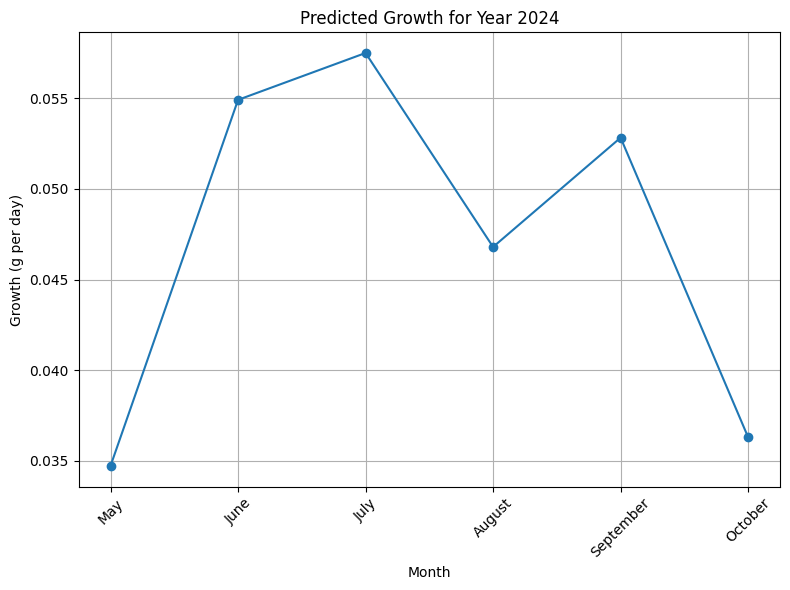

,Month,Growth (g per day)
0,May,0.034715
1,June,0.054914
2,July,0.057500
3,August,0.046796
4,September,0.052826
5,October,0.036298


In [16]:
# Contoh penggunaan fungsi prediksi
year = 2024
lat = 52.3676
lon = 4.9041
initial_weight = 2.0
depth = 10.0
avg_flow_speed = 0.5
max_flow_speed = 1.0

predicted_growth = predict_growth(year, lat, lon, initial_weight, depth, avg_flow_speed, max_flow_speed)
predicted_growth